# 01 - Upstream QC

In [1]:
from libraries import *
from parameters import *

In [2]:
%load_ext rpy2.ipython

In [3]:
os.getcwd()
os.chdir(projectDir)

## Parameters

In [4]:
conf_mt_prefix = 'MT-' if par_species == 'human' else 'mt-'

***

## Read the sample sheet and data sets

Load the sample sheet storing the metadata of the samples. Index column must include the unique h5ad or h5 file name. "sample_name" and "raw" are two mandatory columns, which stands for the unique sample identifier and whether the samples are the raw counts or not (True or False). Additional columns can be possible batch effects such as library name or sequencing channel.

In [5]:
conf_sample_sheet = pd.read_csv(Path(par_data_dir) / 'samples.csv').set_index('h5ad_or_h5_path')
conf_sample_sheet

sample_name   raw round  channel
h5ad_or_h5_path                                 
E3-1-raw.h5            E3-1  True    E3        1
E3-2-raw.h5            E3-2  True    E3        2
E3-3-raw.h5            E3-3  True    E3        3
E3-4-raw.h5            E3-4  True    E3        4
E3-5-raw.h5            E3-5  True    E3        5
E3-6-raw.h5            E3-6  True    E3        6
E3-7-raw.h5            E3-7  True    E3        7
E3-8-raw.h5            E3-8  True    E3        8
E3-9-raw.h5            E3-9  True    E3        9
E3-10-raw.h5          E3-10  True    E3       10
E3-11-raw.h5          E3-11  True    E3       11
E3-12-raw.h5          E3-12  True    E3       12
E3-13-raw.h5          E3-13  True    E3       13
E3-14-raw.h5          E3-14  True    E3       14
E3-15-raw.h5          E3-15  True    E3       15
E3-16-raw.h5          E3-16  True    E3       16
E3-17-raw.h5          E3-17  True    E3       17
E3-18-raw.h5          E3-18  True    E3       18
E3-19-raw.h5          E3-19  True    E3       19
E3-20-raw.h5          E3-20  True    E3       20
E3-21-raw.h5          E3-21  True    E3       21
E3-22-raw.h5          E3-22  True    E3       21
E3-23-raw.h5          E3-23  True    E3       23
E3-24-raw.h5          E3-24  True    E3       24
E4-1-raw.h5            E4-1  True    E4        1
E4-2-raw.h5            E4-2  True    E4        2
E4-3-raw.h5            E4-3  True    E4        3
E4-4-raw.h5            E4-4  True    E4        4
E4-5-raw.h5            E4-5  True    E4        5
E4-6-raw.h5            E4-6  True    E4        6
E4-7-raw.h5            E4-7  True    E4        7
E4-8-raw.h5            E4-8  True    E4        8
E4-9-raw.h5            E4-9  True    E4        9
E4-10-raw.h5          E4-10  True    E4       10
E4-11-raw.h5          E4-11  True    E4       11
E4-12-raw.h5          E4-12  True    E4       12
E4-13-raw.h5          E4-13  True    E4       13
E4-14-raw.h5          E4-14  True    E4       14
E4-15-raw.h5          E4-15  True    E4       15
E4-16-raw.h5          E4-16  True    E4       16
E4-17-raw.h5          E4-17  True    E4       17
E4-19-raw.h5          E4-19  True    E4       19
E4-20-raw.h5          E4-20  True    E4       20
E4-21-raw.h5          E4-21  True    E4       21
E4-22-raw.h5          E4-22  True    E4       22
E4-24-raw.h5          E4-24  True    E4       24

In [6]:
conf_n_samples = len(conf_sample_sheet)

conf_plotting_n_cols = 5
conf_plotting_width = 20
conf_plotting_height_per_row = 3.5

conf_plotting_n_rows = math.ceil(conf_n_samples/conf_plotting_n_cols)
conf_sample_features = conf_sample_sheet.columns.tolist()

In [7]:
assert 'sample_name' in conf_sample_sheet.columns, 'Sample sheet must have a unique sample_name column'
assert 'raw' in conf_sample_sheet.columns, 'Sample sheet must have a raw (True or False) column'
assert conf_sample_sheet.sample_name.nunique() == conf_n_samples, 'Sample sheet must have a unique sample_name column'

## Tools for prefiltered data

In [8]:
def emptydrops(adata, lower, niters, ignore, retain=None, seed=0, **kwargs):
    r('set.seed')(seed)
    du = importr('DropletUtils')
    ed = du.emptyDrops(adata.X.T,
                       lower=lower,
                       niters=niters,
                       ignore=ignore,
                       retain=retain,
                       **kwargs)
    fdr = r('`[[`')(ed, 'FDR')
    adata.obs['empty_drops_FDR'] = fdr

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fdr[fdr == 0.0] = 1.0/niters

        adata.obs['neg_log10_empty_drops_FDR'] = -np.log10(fdr)

## Store QC info and run tools on prefiltered data

In [9]:
%%time

conf_samples = {}

for sample in tqdm(list(conf_sample_sheet.itertuples())):
    file = Path(par_data_dir) / sample.Index

    if str(sample.raw).lower() == 'true':
        ad = sc.read_10x_h5(file).copy()
    else:
        ad = sc.read(file)

    ad.var_names_make_unique()
    display(ad)
    

    for sample_feature in conf_sample_features:
        ad.obs[sample_feature] = sample._asdict()[sample_feature]

    if str(sample.raw).lower() == 'true':
        # EmptyDrops
        emptydrops(ad,
                   lower=par_empty_drops_lower_umi_cutoff,
                   niters=par_empty_drops_niters,
                   ignore=par_empty_drops_ignore_cutoff,
                   retain=par_empty_drops_retain)
    else:
        ad.obs['empty_drops_FDR'] = np.nan
        ad.obs['neg_log10_empty_drops_FDR'] = np.nan

    ad.obs['n_umis']  = ad.X.sum(1)
    ad.obs['n_genes'] = (ad.X != 0).sum(1).A1
    ad.obs['log10_n_umis'] = np.log10(ad.X.sum(1))
    ad.obs['log10_n_genes'] = np.log10((ad.X != 0).sum(1).A1)

    # Total UMI/gene cutoffs
    ad = ad[ad.obs.n_umis  > par_initial_umi_cutoff]
    ad = ad[ad.obs.n_genes > par_initial_gene_cutoff]
    display(ad)

    # Save barcode rank
    ad.obs['barcode_rank'] = scipy.stats.rankdata(-ad.obs['n_umis'])

    # MT
    mt_gene_mask = ad.var_names.str.startswith(conf_mt_prefix)
    assert mt_gene_mask.sum() > 0, 'Wrong mt prefix'
    ad.obs['mt_frac'] = ad.X[:, mt_gene_mask].sum(1).A1 / ad.obs['n_umis']

    conf_samples[sample.sample_name] = ad.copy()

  0%|          | 0/46 [00:00<?, ?it/s]

reading data/E3-1-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 22667 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-2-raw.h5
 (0:00:11)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23157 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-3-raw.h5
 (0:00:11)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23149 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-4-raw.h5
 (0:00:11)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 15597 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-5-raw.h5
 (0:00:11)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 22478 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-6-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23657 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-7-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23488 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-8-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23547 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-9-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24281 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-10-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24685 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-11-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23040 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-12-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 25157 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-13-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24724 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-14-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24498 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-15-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23893 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-16-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23027 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-17-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 25249 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-18-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 27108 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-19-raw.h5
 (0:00:06)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 6861 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

reading data/E3-20-raw.h5


<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 26527 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-21-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 27159 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-22-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24658 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-23-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 26939 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E3-24-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24078 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-1-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24377 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-2-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 26724 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-3-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23882 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-4-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 26932 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-5-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 25311 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-6-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 21886 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-7-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23609 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-8-raw.h5
 (0:00:09)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 22356 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-9-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 25987 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-10-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24466 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-11-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23273 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-12-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 24844 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-13-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 25585 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-14-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 26627 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-15-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 26867 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-16-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 28477 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-17-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 21873 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-19-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 23416 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-20-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 22379 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-21-raw.h5
 (0:00:07)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 12969 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-22-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 21604 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


reading data/E4-24-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:31: RuntimeWarning: divide by zero encountered in log10
<timed exec>:32: RuntimeWarning: divide by zero encountered in log10


View of AnnData object with n_obs × n_vars = 22946 × 31053
    obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

<timed exec>:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


CPU times: user 2h 5min 41s, sys: 6min 30s, total: 2h 12min 12s
Wall time: 2h 12min 23s


## UMI/Gene Rank Plots

  0%|          | 0/46 [00:00<?, ?it/s]

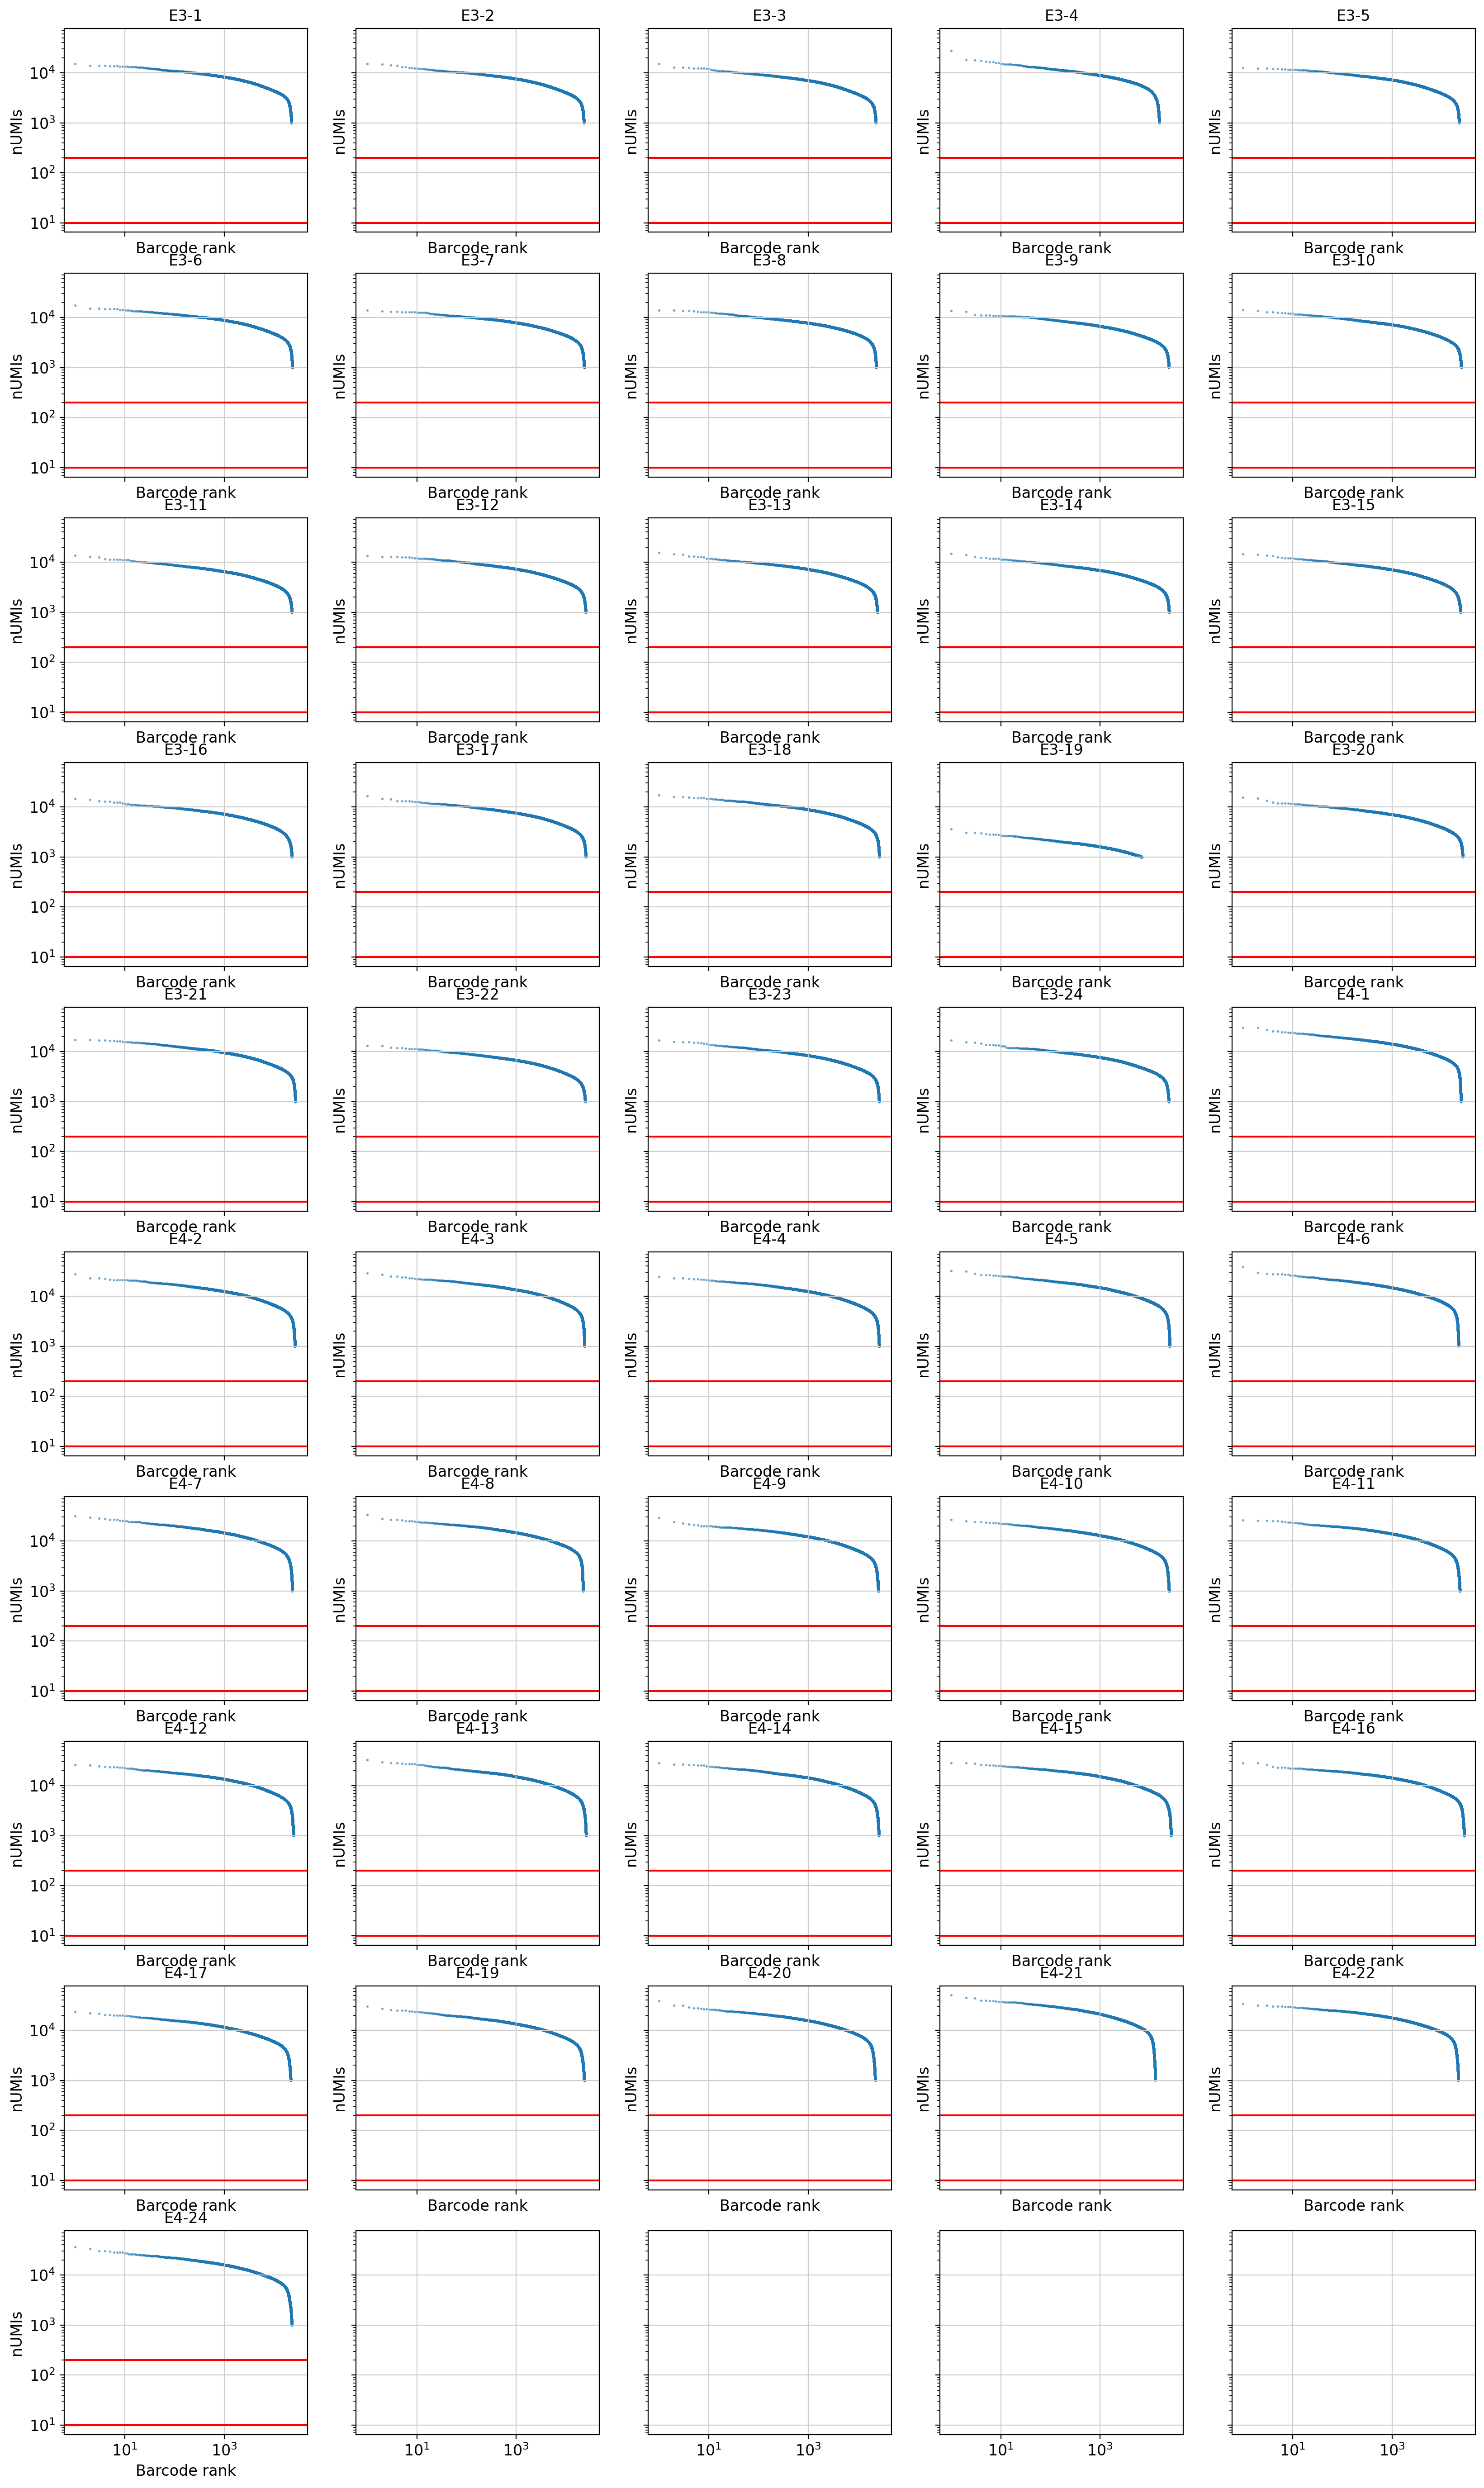

In [10]:
f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.scatter(ad.obs.barcode_rank.values,
               ad.obs.n_umis.values,
               s=1, alpha=0.5)

    ax.axhline(par_empty_drops_ignore_cutoff, color='red')
    ax.axhline(par_empty_drops_lower_umi_cutoff, color='red')

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlabel('Barcode rank')
    ax.set_ylabel('nUMIs')

    ax.set_title(sample)

plt.subplots_adjust()

## nGenes vs nUMIs and distributions

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

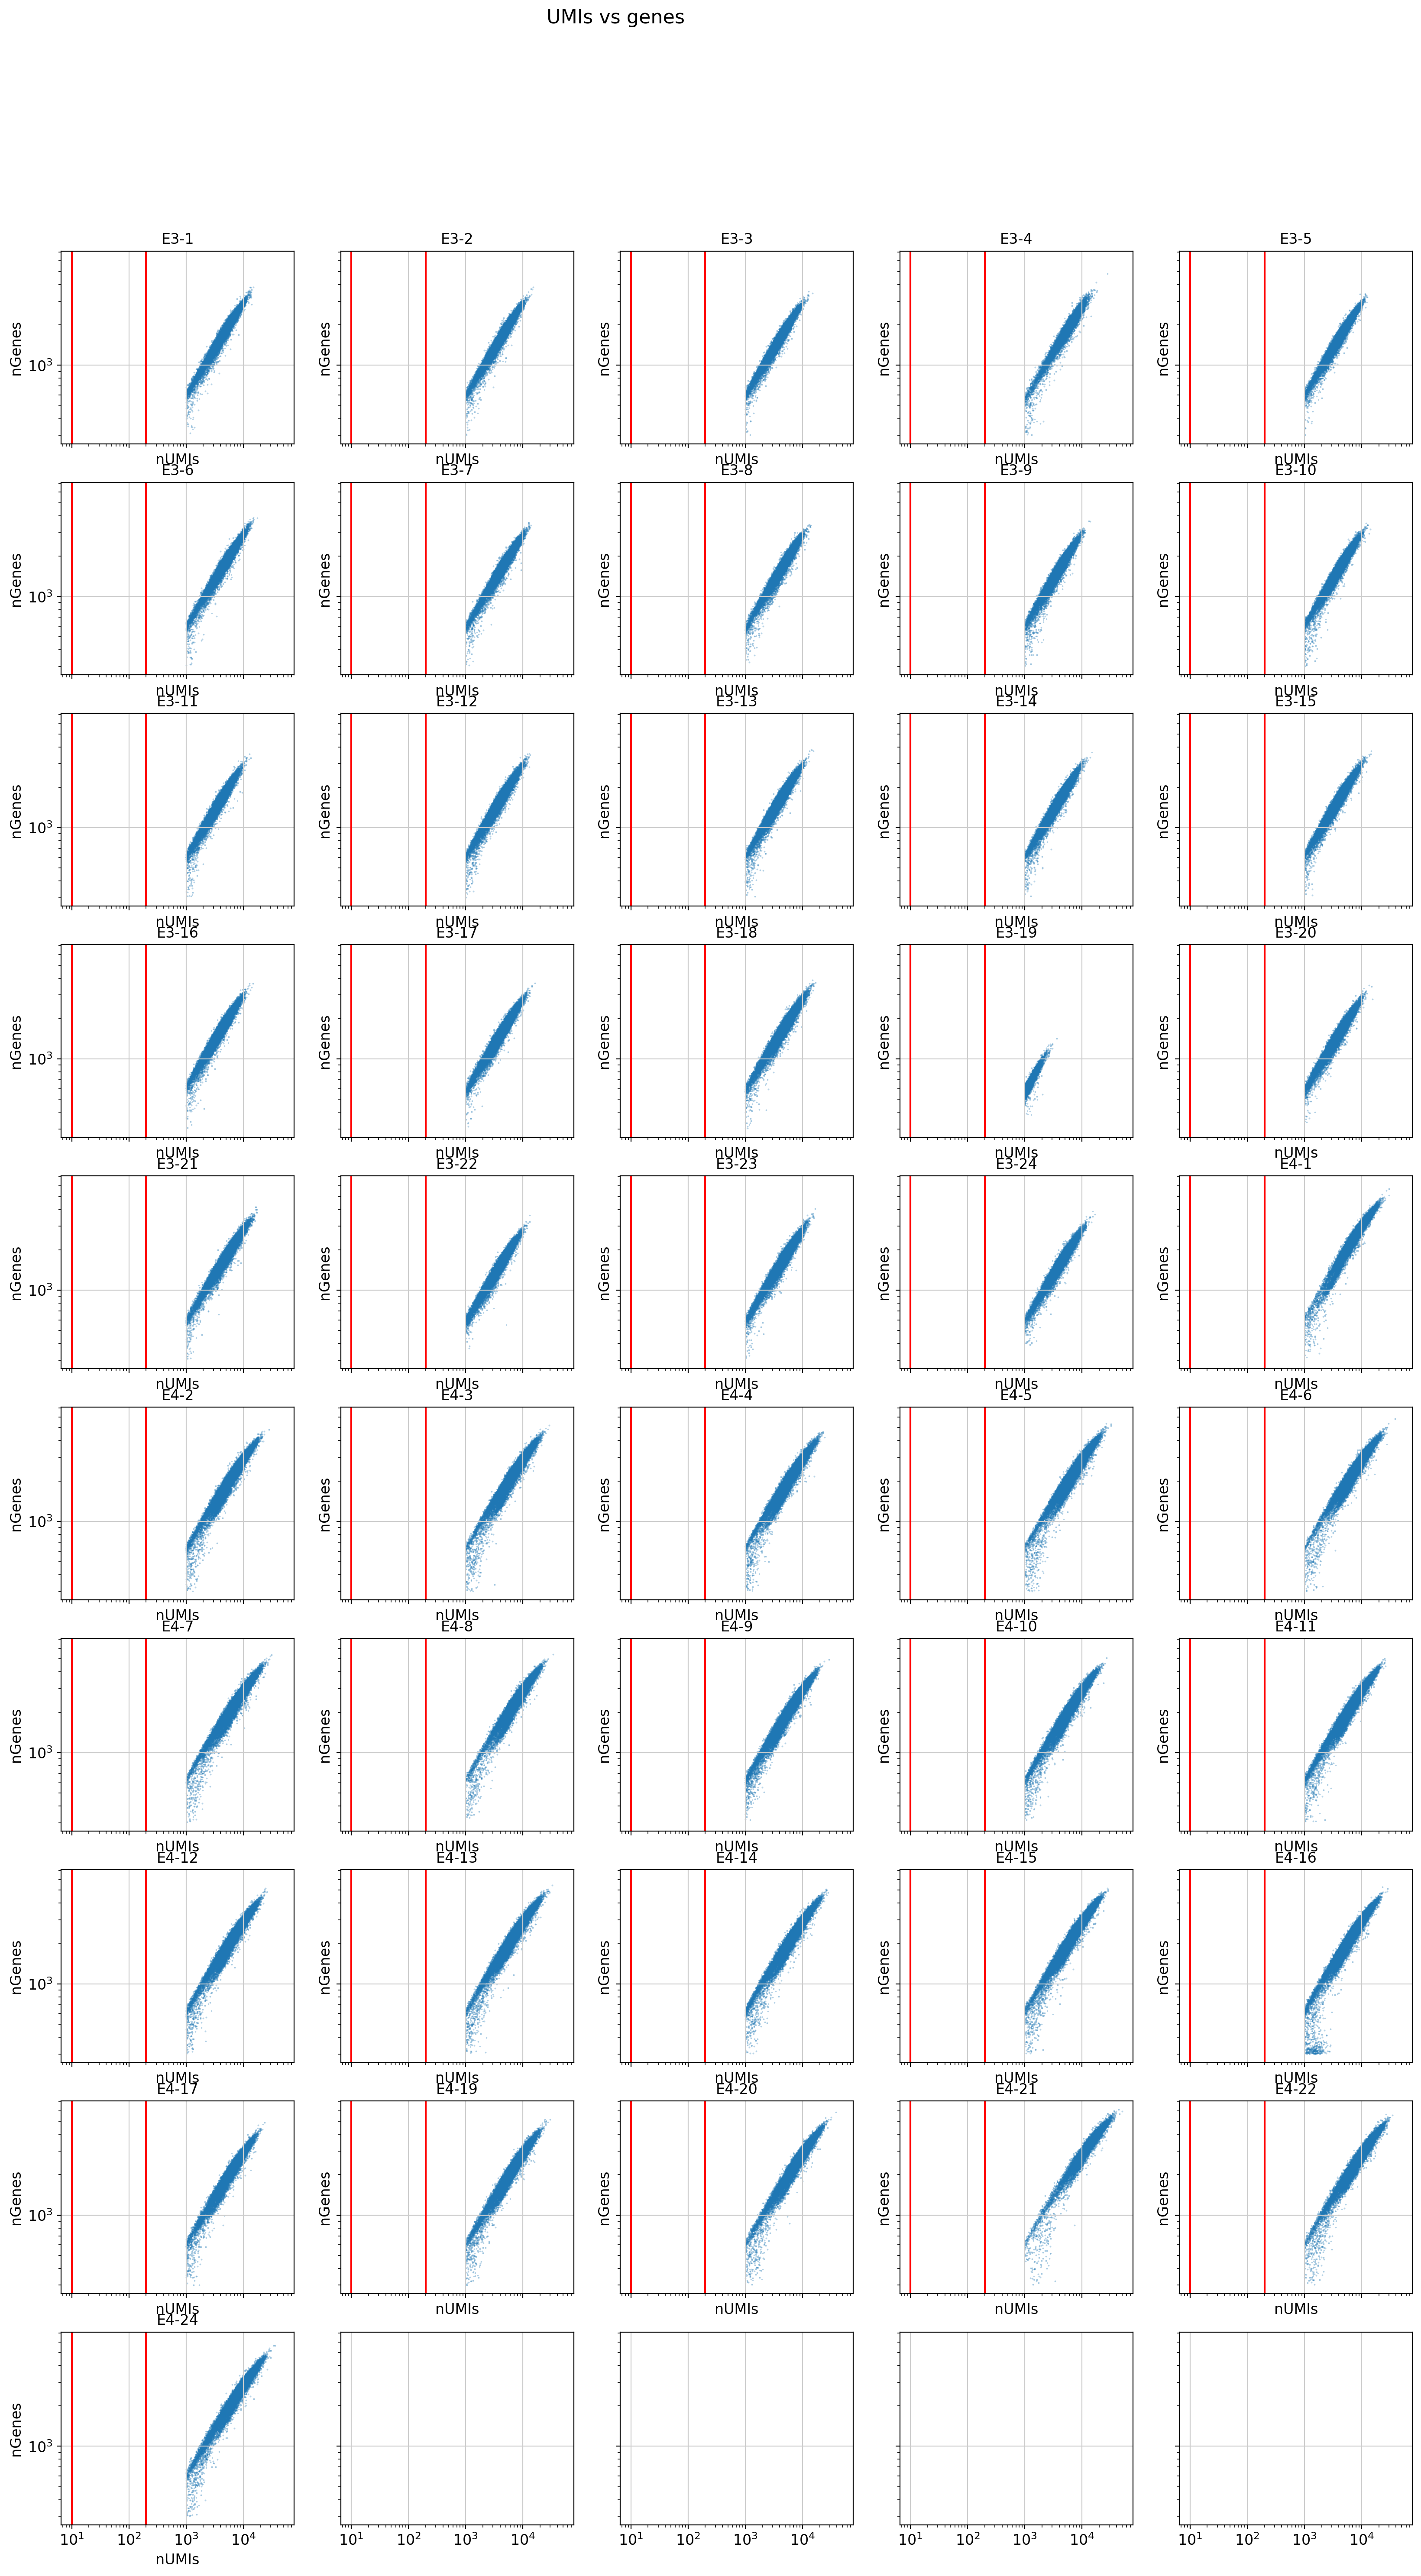

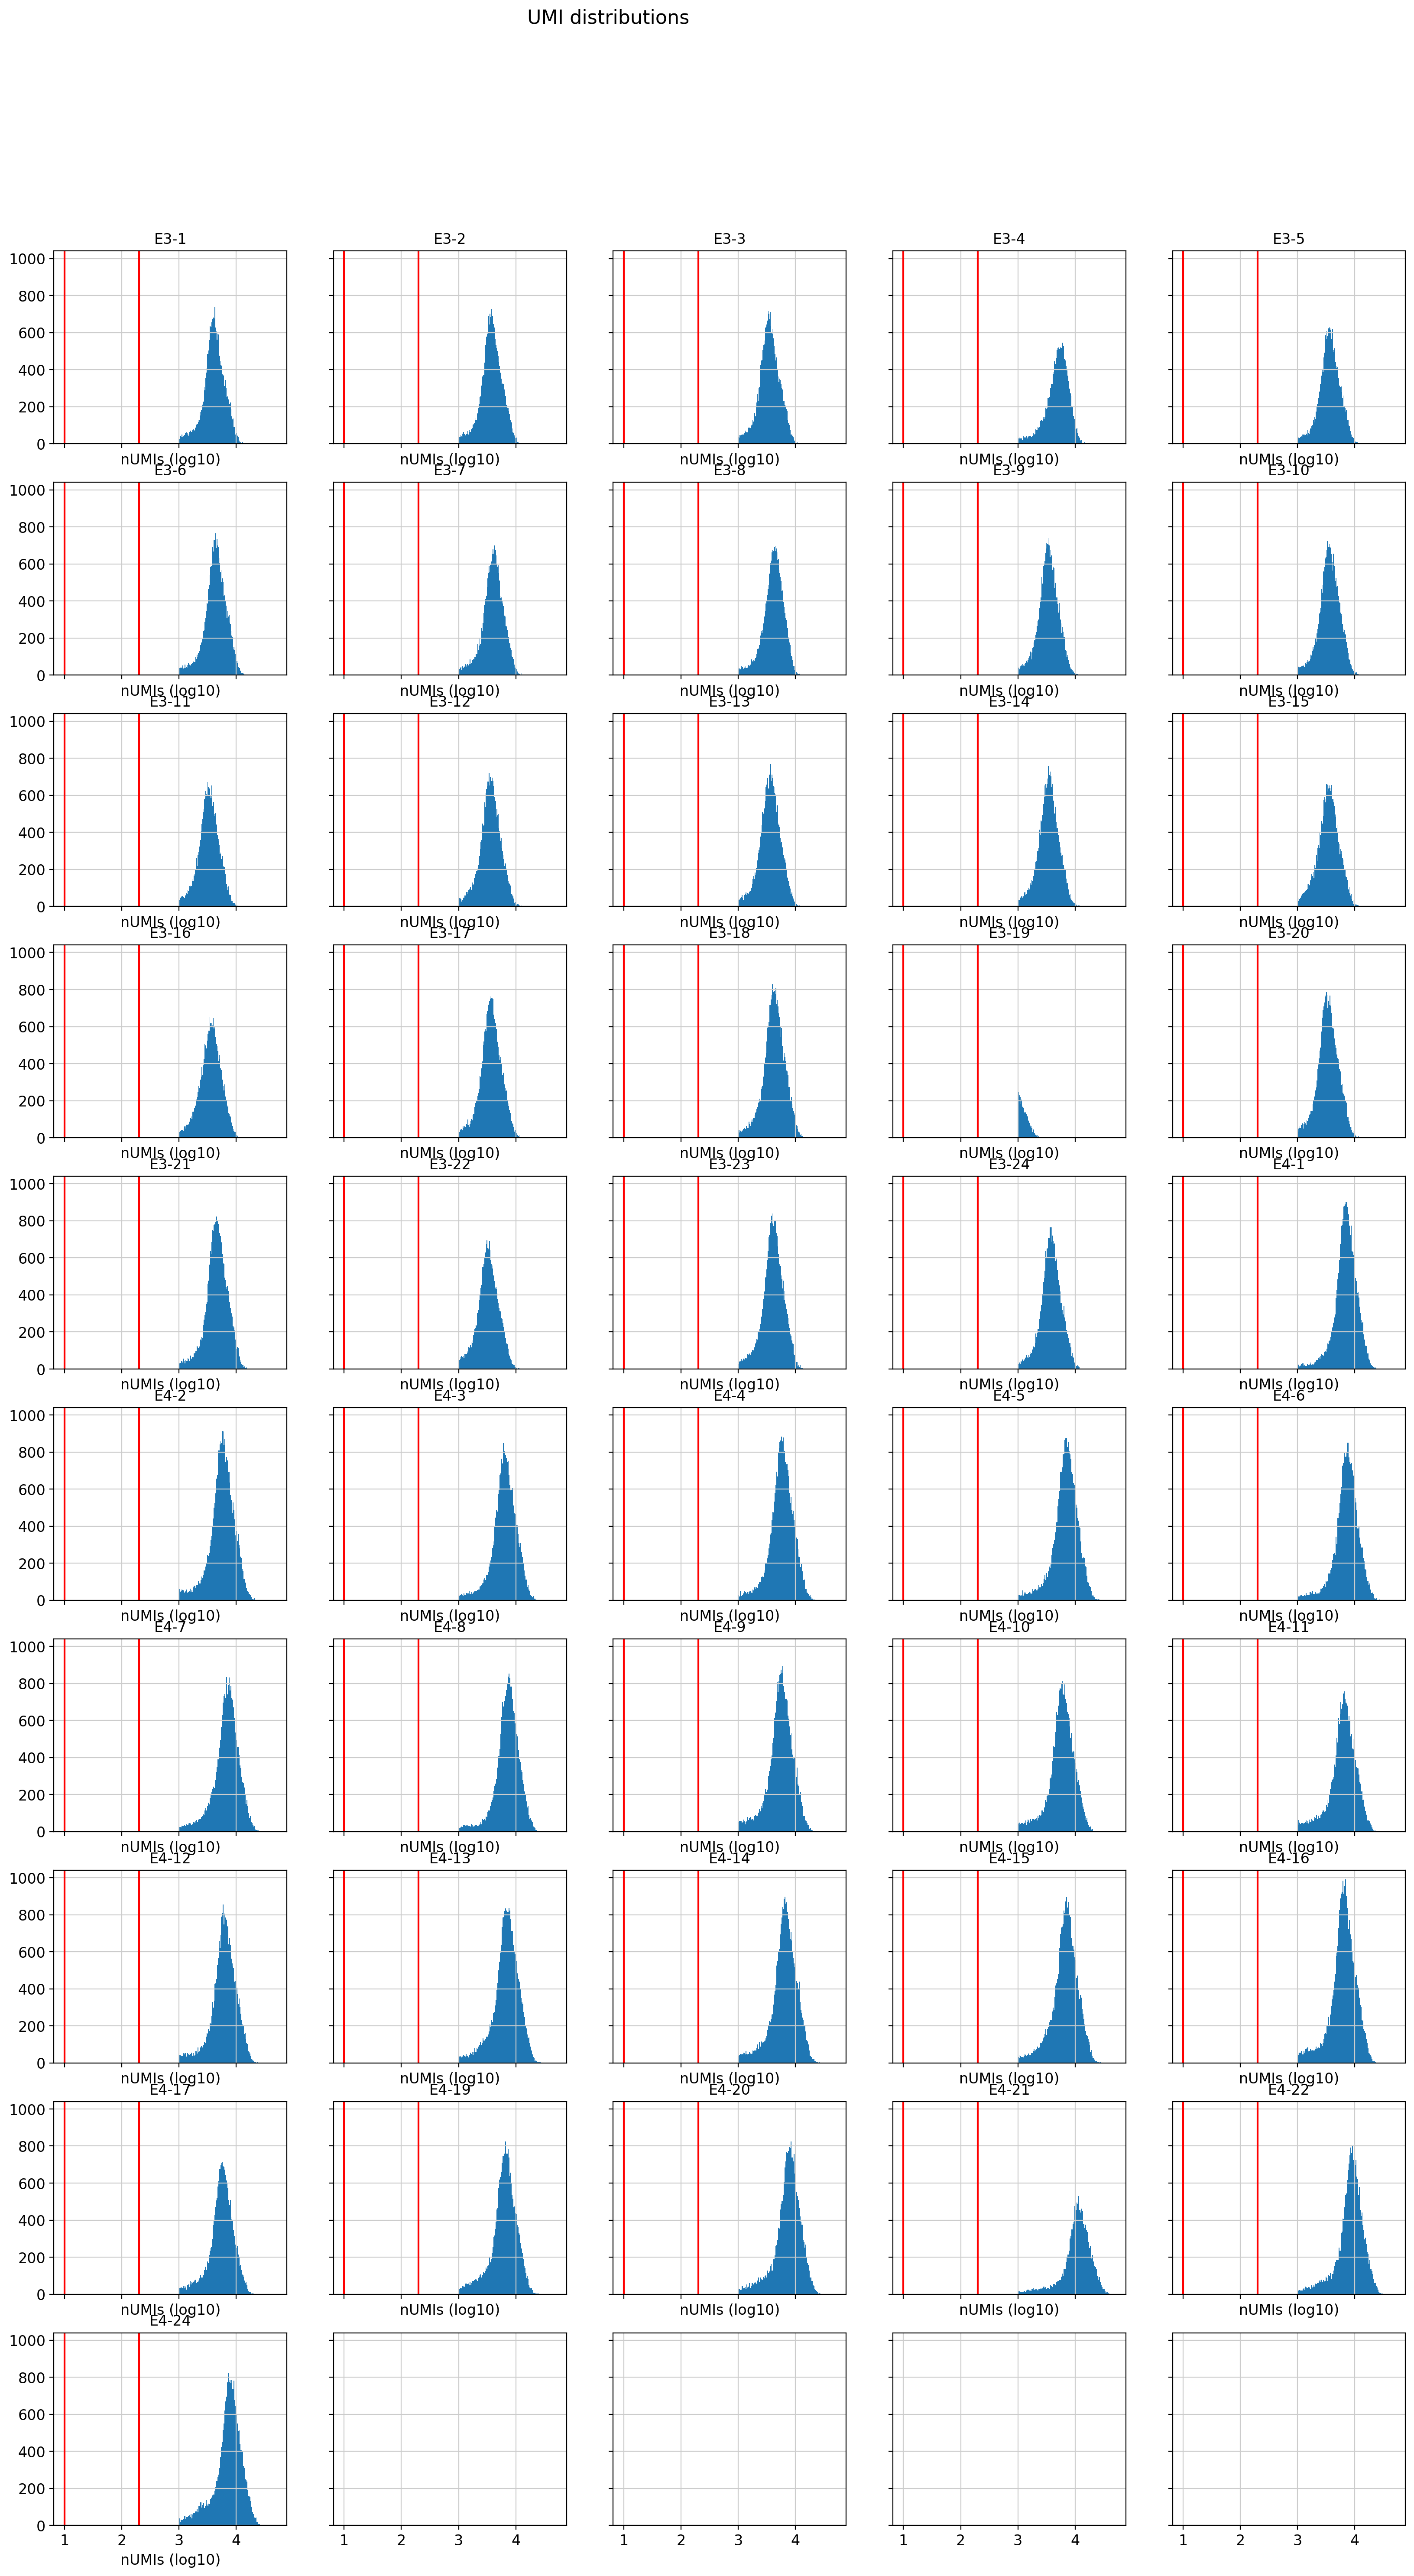

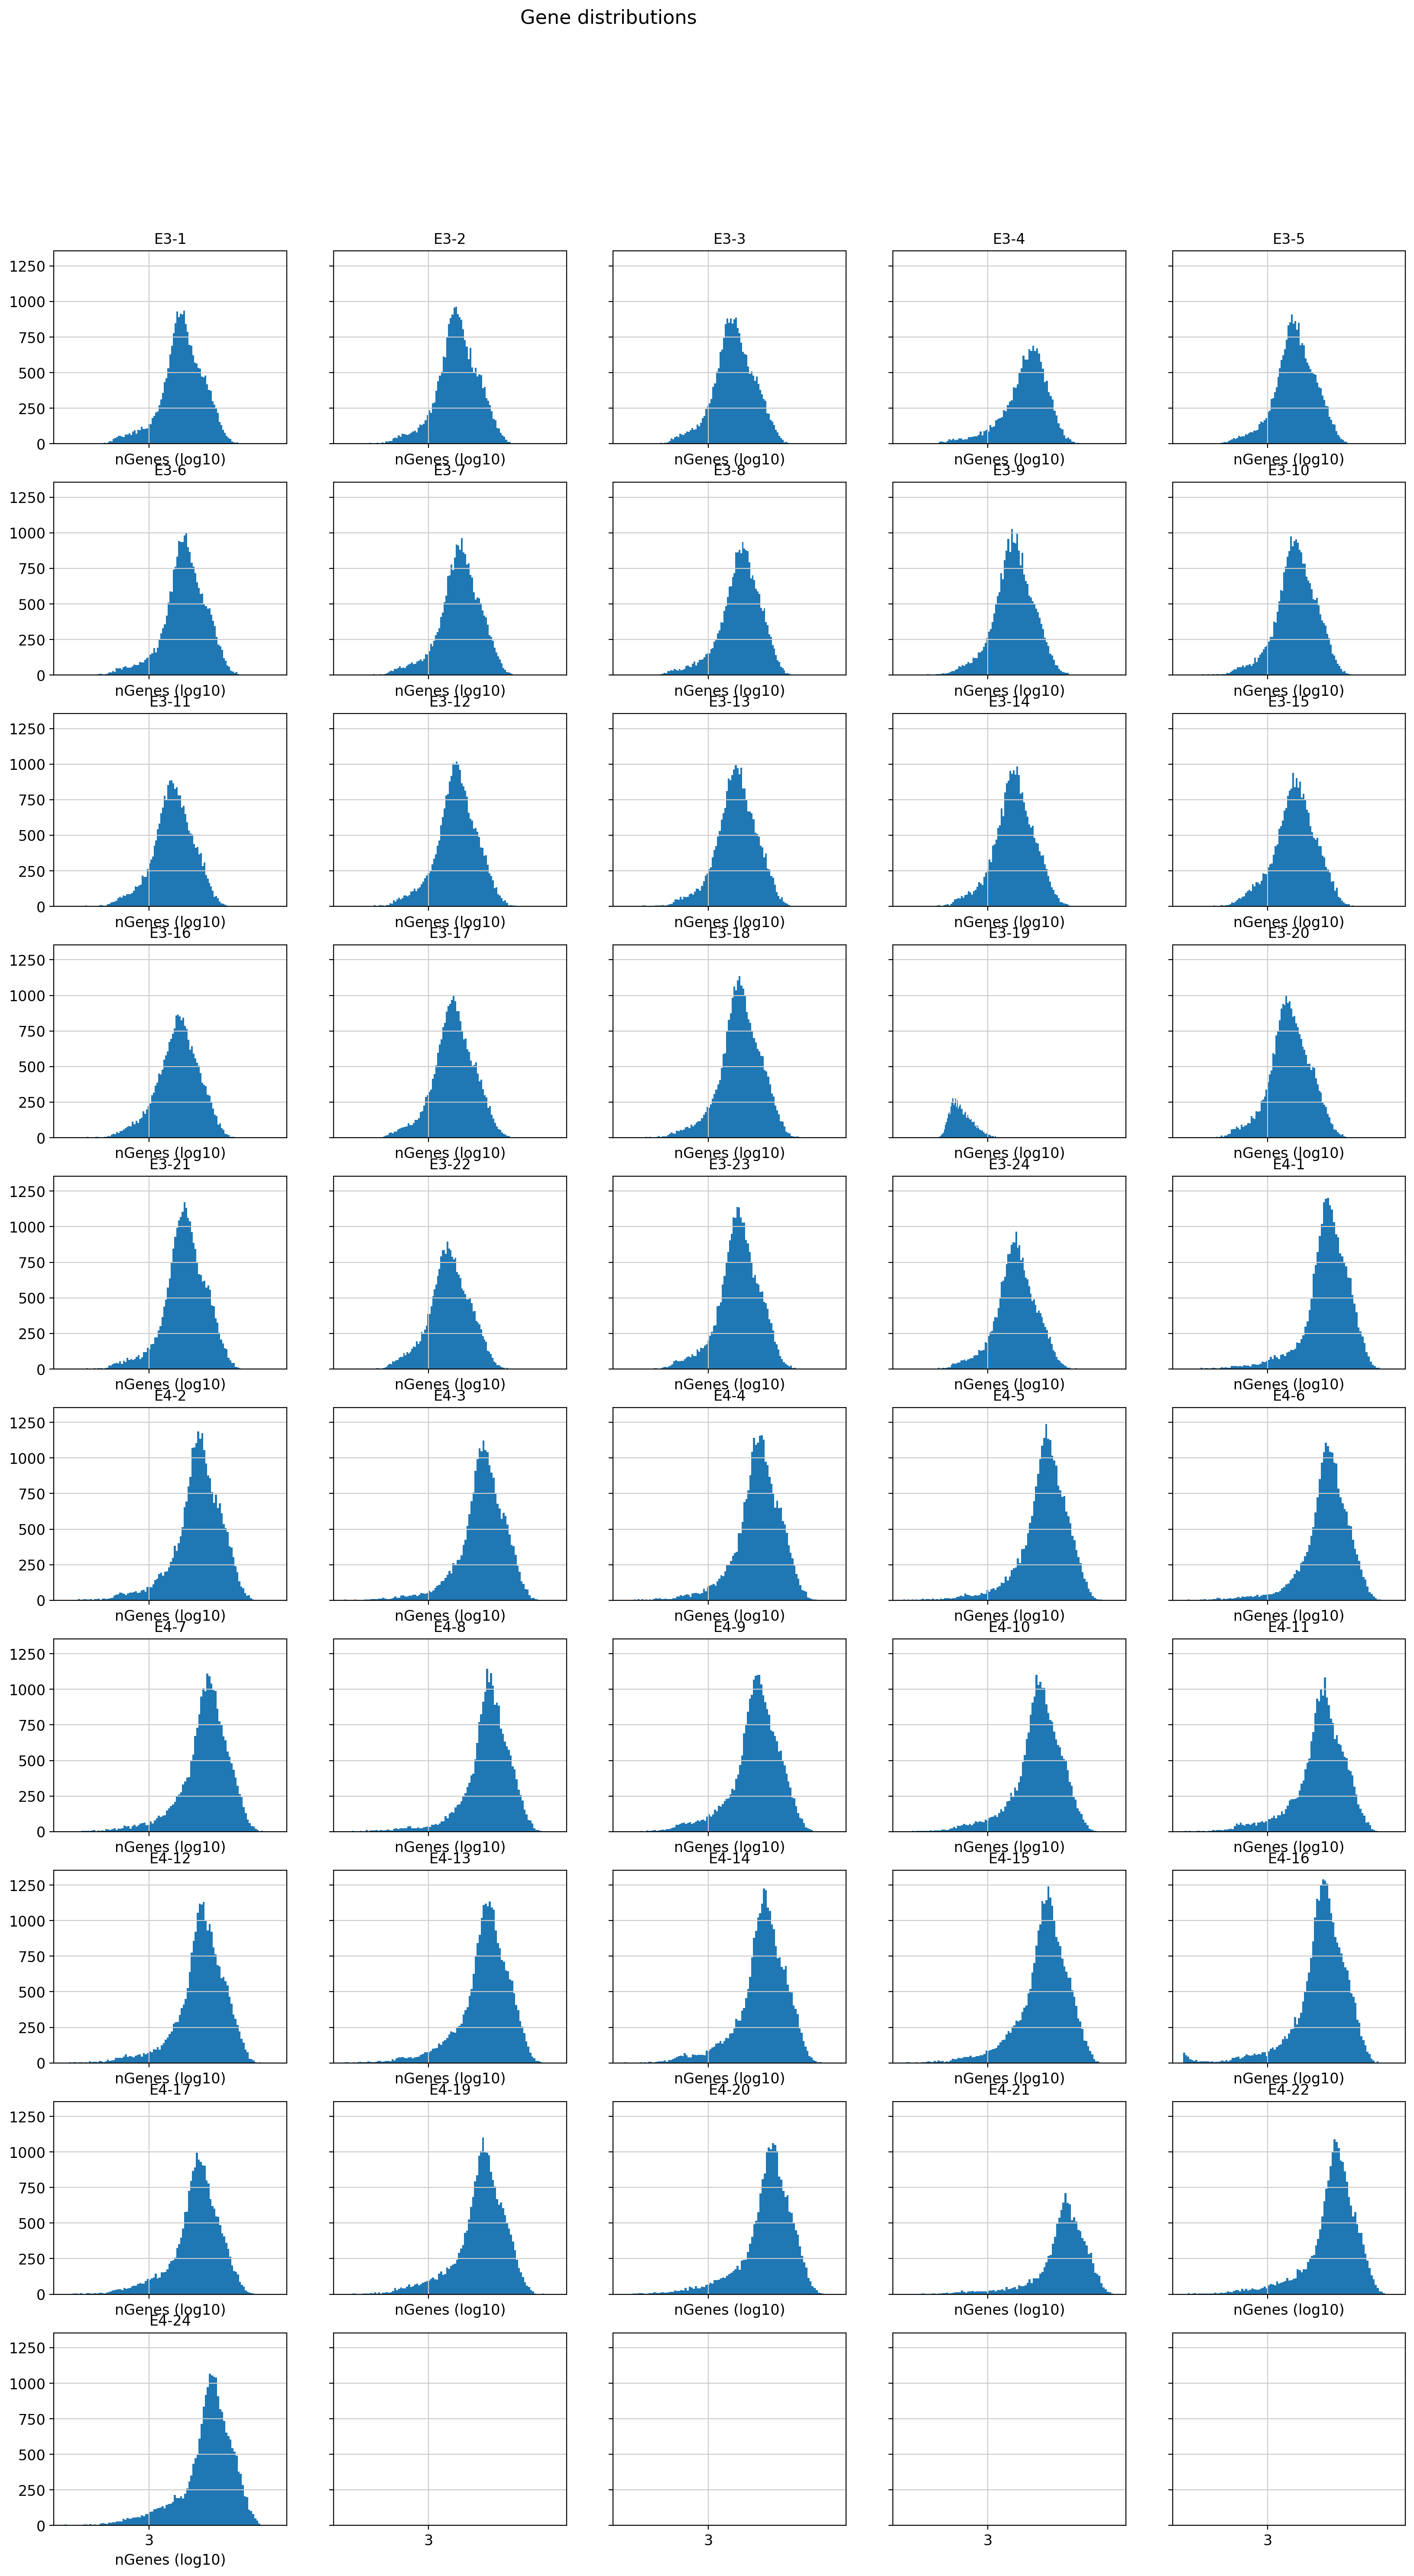

In [11]:
f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.scatter(ad.obs.n_umis.values+1,
               ad.obs.n_genes.values+1,
               alpha=0.5,
               s=0.1)
    ax.axvline(par_empty_drops_ignore_cutoff, color='red')
    ax.axvline(par_empty_drops_lower_umi_cutoff, color='red')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(sample)

    ax.set_xlabel('nUMIs')
    ax.set_ylabel('nGenes')


f.suptitle('UMIs vs genes', fontsize=16)
plt.subplots_adjust(top=0.9)

## UMI distr.

f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.hist(ad.obs.log10_n_umis.values, bins=100)
    ax.axvline(np.log10(par_empty_drops_ignore_cutoff), color='red')
    ax.axvline(np.log10(par_empty_drops_lower_umi_cutoff), color='red')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(sample)
    ax.set_xlabel('nUMIs (log10)')

f.suptitle('UMI distributions', fontsize=16)
plt.subplots_adjust(top=0.9)

## Gene distr.

f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.hist(ad.obs.log10_n_genes.values, bins=100)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(sample)
    ax.set_xlabel('nGenes (log10)')

f.suptitle('Gene distributions', fontsize=16)
plt.subplots_adjust(top=0.9)

## nGenes vs nUMIs and distributions (with EmptyDrops)

  0%|          | 0/46 [00:00<?, ?it/s]

/tmp/ipykernel_13610/1298322084.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f.colorbar(pc, cax=cax, orientation='vertical')


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

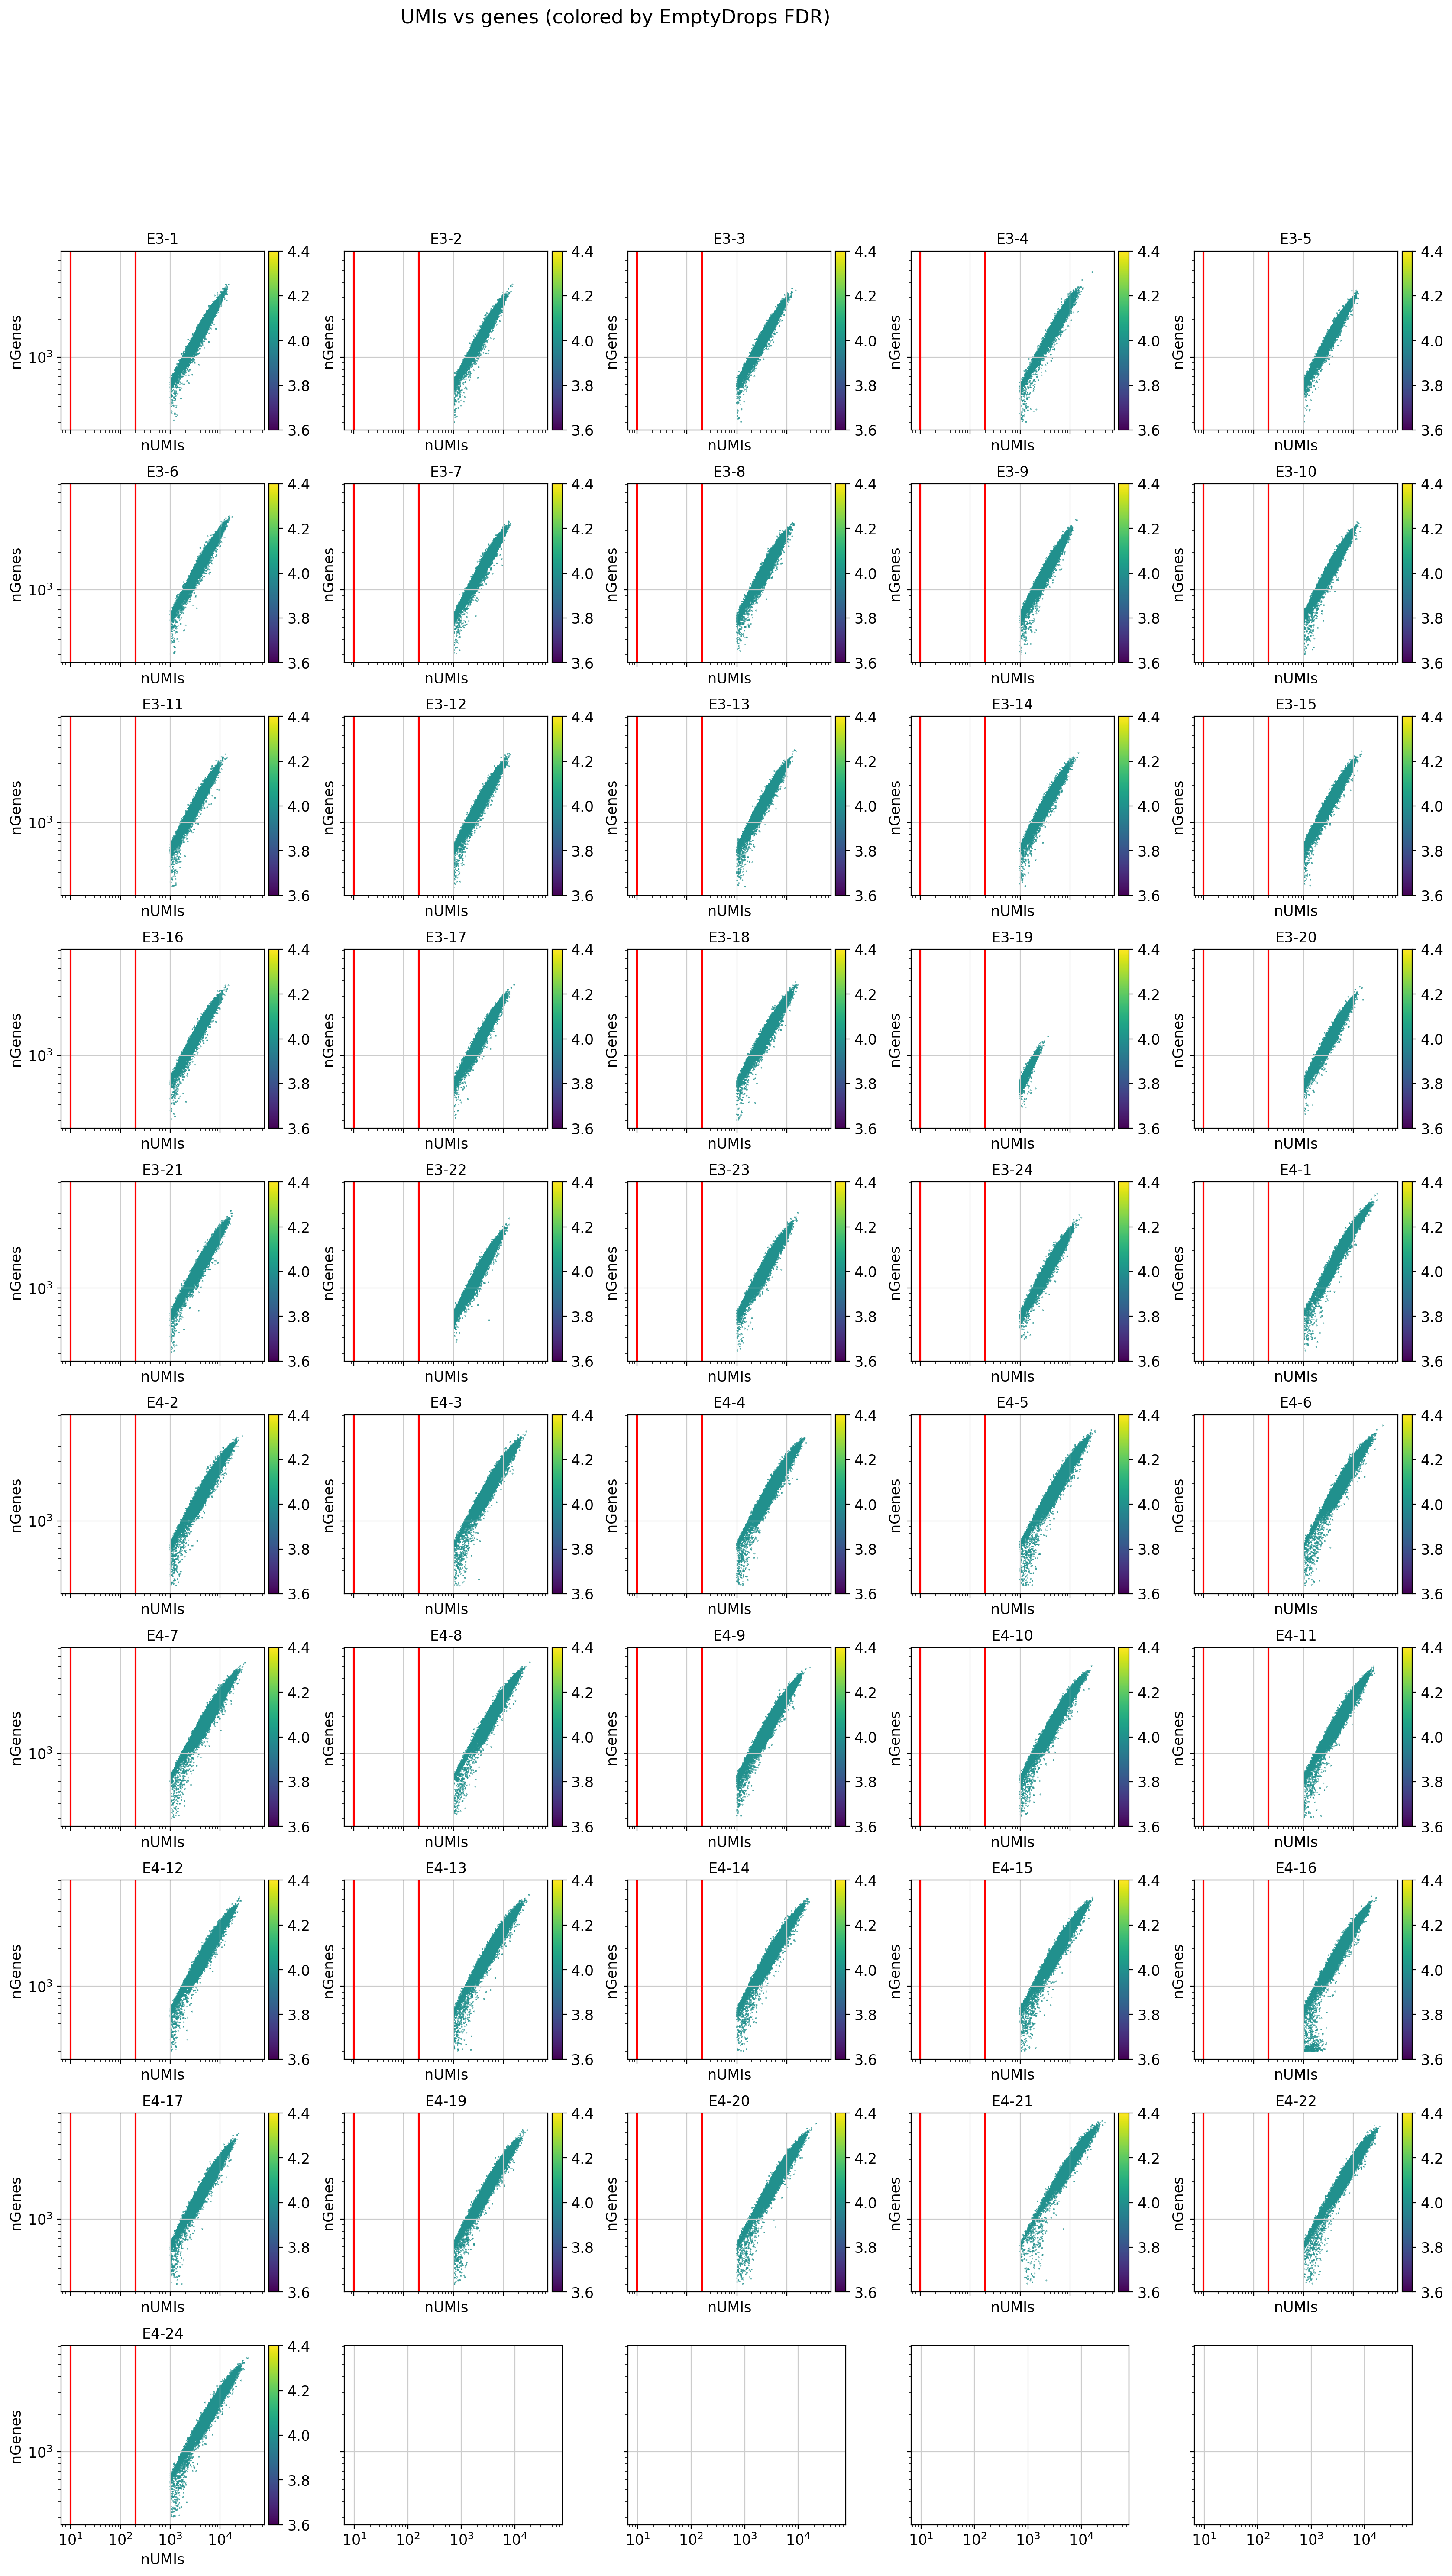

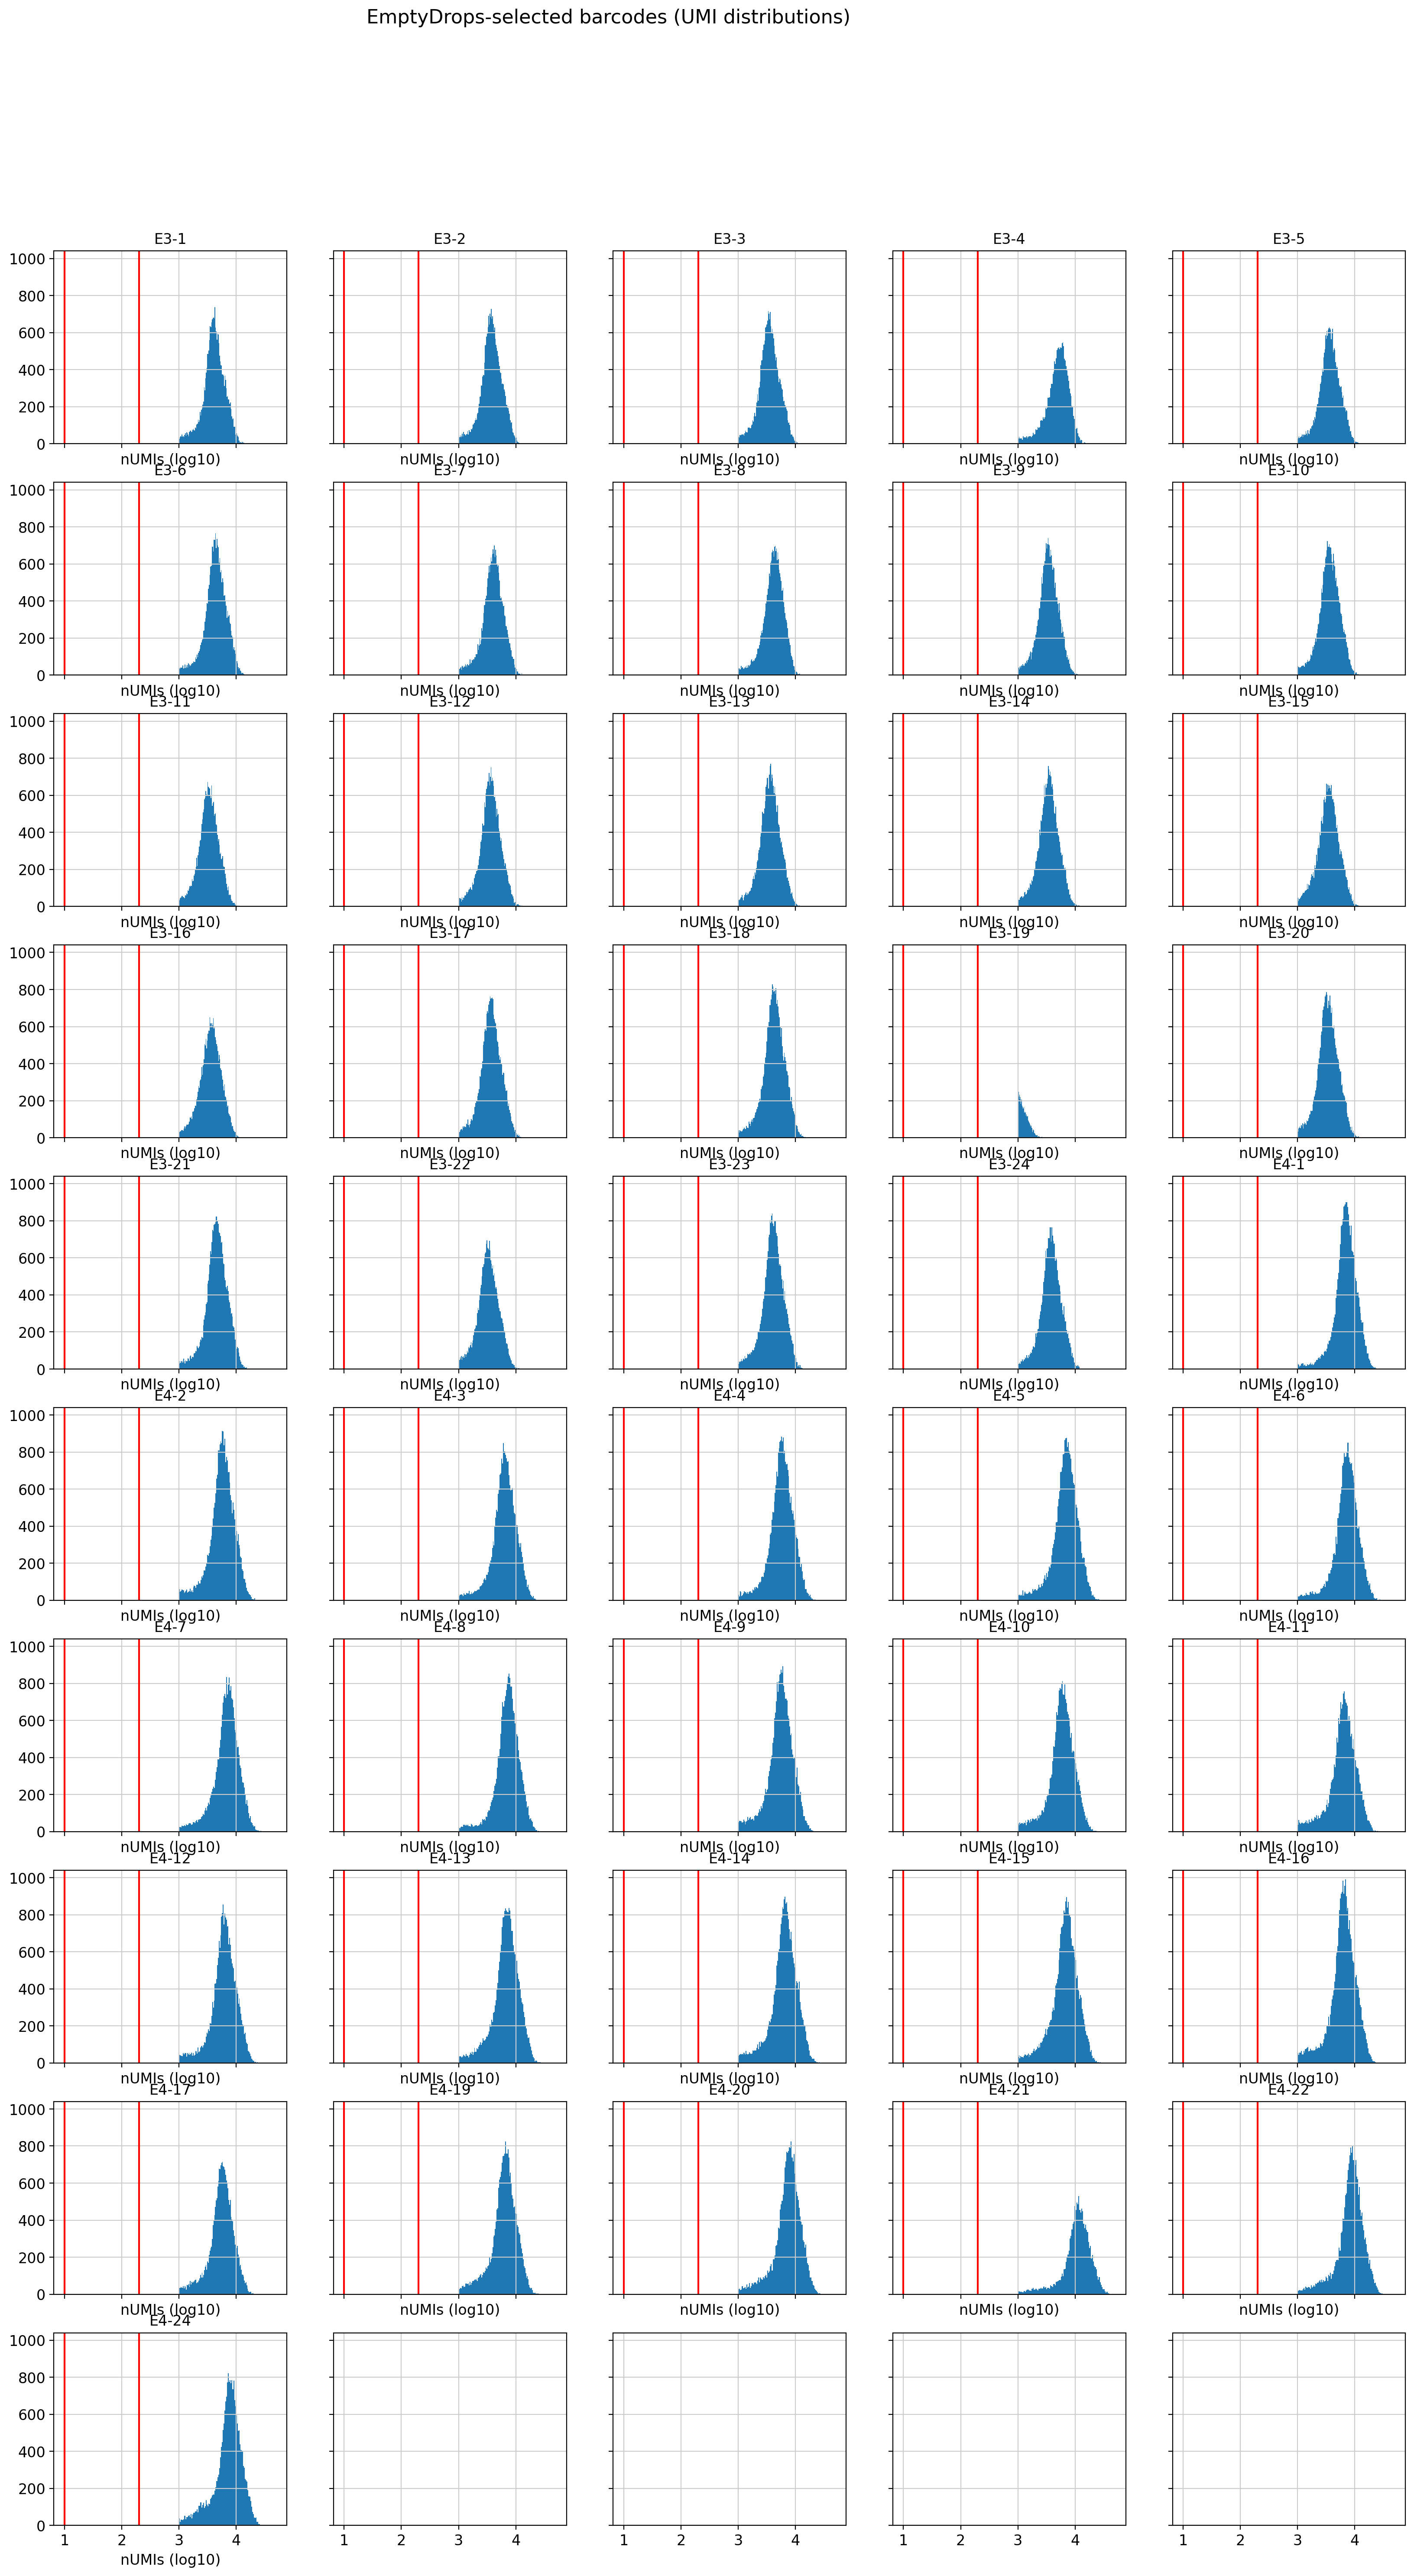

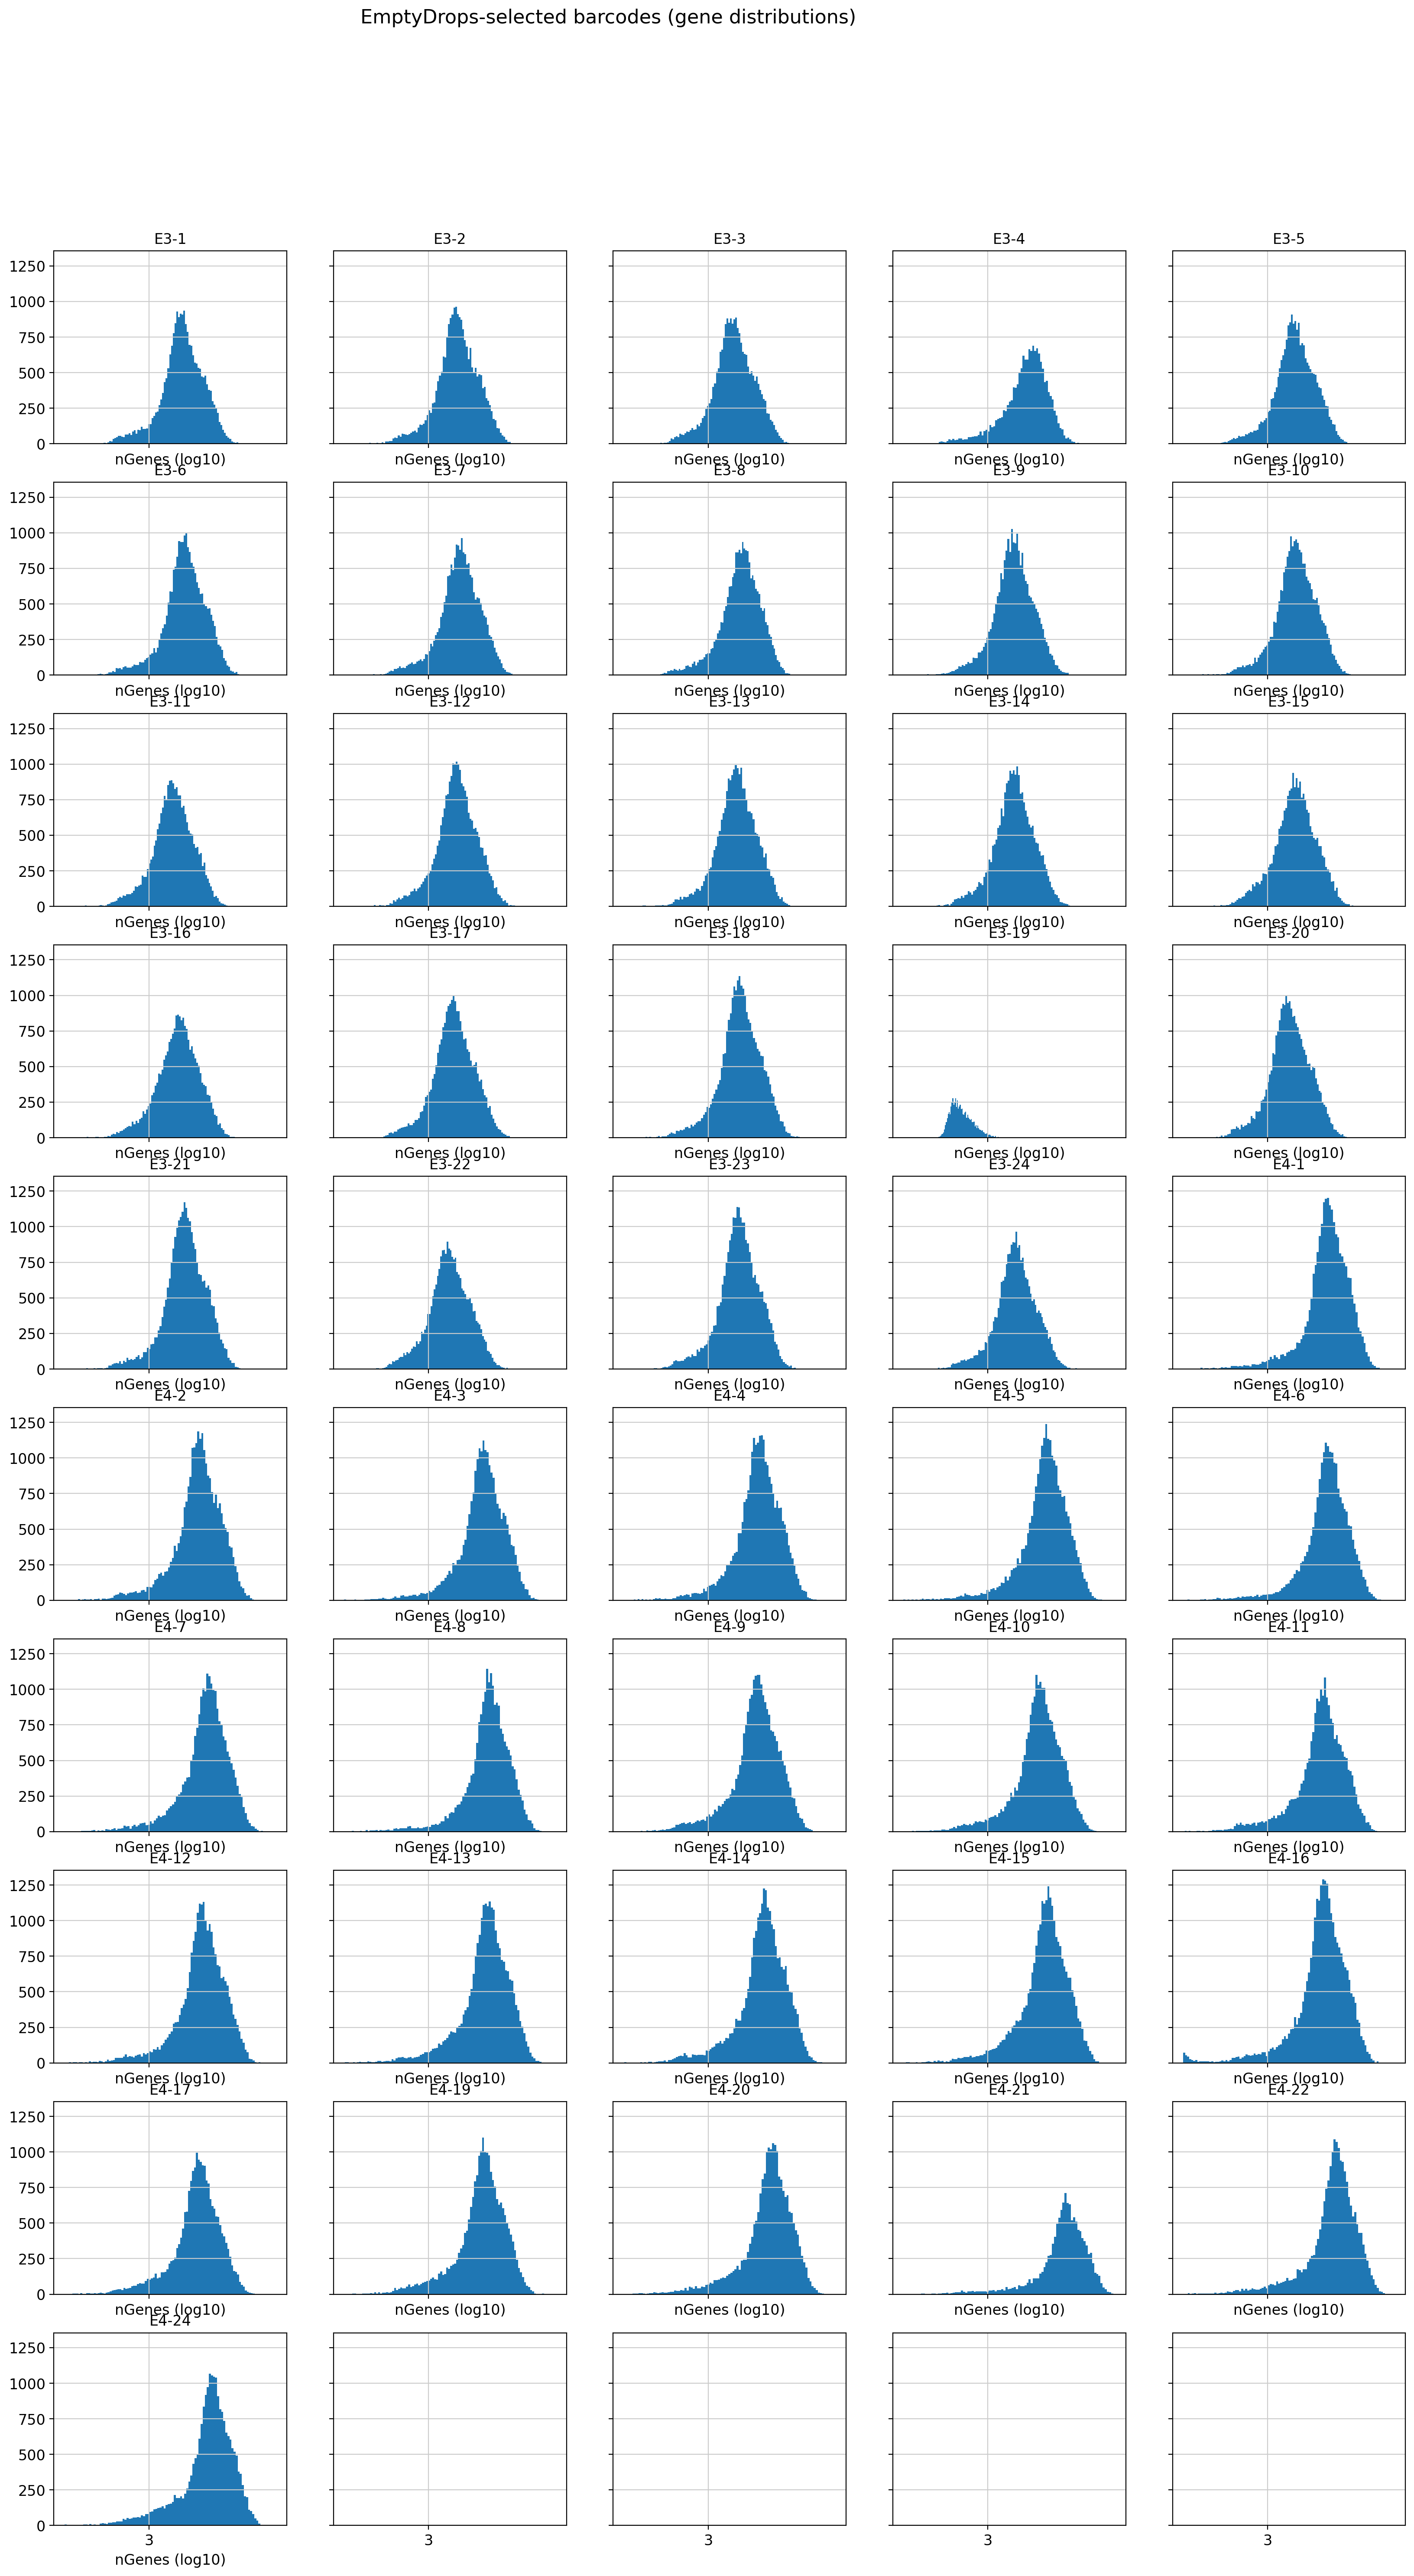

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

if (conf_sample_sheet.raw.astype(str).str.lower() == 'true').any():

    f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                          figsize=(conf_plotting_width,
                                   conf_plotting_n_rows*conf_plotting_height_per_row),
                          sharey=True, sharex=True)
    axs = axs.flatten()

    for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
        if np.any(np.isfinite(ad.obs.neg_log10_empty_drops_FDR)):
            idx = np.argsort(ad.obs.neg_log10_empty_drops_FDR)[::-1]
            ad = ad[idx]

            pc = ax.scatter(ad.obs.n_umis.values+1,
                            ad.obs.n_genes.values+1,
                            s=0.1,
                            c=ad.obs.neg_log10_empty_drops_FDR)
            ax.axvline(par_empty_drops_ignore_cutoff, color='red')
            ax.axvline(par_empty_drops_lower_umi_cutoff, color='red')

            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_title(sample)

            ax.set_xlabel('nUMIs')
            ax.set_ylabel('nGenes')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            f.colorbar(pc, cax=cax, orientation='vertical')

    f.suptitle('UMIs vs genes (colored by EmptyDrops FDR)', fontsize=16)
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9)

    ## UMI distr.

    f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                          figsize=(conf_plotting_width,
                                   conf_plotting_n_rows*conf_plotting_height_per_row),
                          sharey=True, sharex=True)
    axs = axs.flatten()

    for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
        if np.any(np.isfinite(ad.obs.neg_log10_empty_drops_FDR)):
            ad = ad[ad.obs.neg_log10_empty_drops_FDR > -np.log10(par_empty_drops_fdr_cutoff)]
            ax.hist(ad.obs.log10_n_umis.values, bins=100)
            ax.axvline(np.log10(par_empty_drops_ignore_cutoff), color='red')
            ax.axvline(np.log10(par_empty_drops_lower_umi_cutoff), color='red')

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.set_title(sample)
            ax.set_xlabel('nUMIs (log10)')

    f.suptitle('EmptyDrops-selected barcodes (UMI distributions)', fontsize=16)
    plt.subplots_adjust(top=0.9)

    # Gene distr.

    f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                          figsize=(conf_plotting_width,
                                   conf_plotting_n_rows*conf_plotting_height_per_row),
                          sharey=True, sharex=True)
    axs = axs.flatten()

    for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
        if np.any(np.isfinite(ad.obs.neg_log10_empty_drops_FDR)):
            ad = ad[ad.obs.neg_log10_empty_drops_FDR > -np.log10(par_empty_drops_fdr_cutoff)]
            x = ad.obs.log10_n_genes.values
            ax.hist(x, bins=100)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.set_title(sample)
            ax.set_xlabel('nGenes (log10)')

    f.suptitle('EmptyDrops-selected barcodes (gene distributions)', fontsize=16)
    plt.subplots_adjust(top=0.9)

## Serialize the session

In [13]:
k = None
var = None

with shelve.open('session_01.pkl', protocol=4, flag='n') as db:
    for k, var in globals().items():
        if k.startswith('par_') or k.startswith('conf_'):
            print(f'Storing {k}...')
            db[k] = var
db.close()

Storing par_species...
Storing par_data_dir...
Storing par_initial_umi_cutoff...
Storing par_initial_gene_cutoff...
Storing par_empty_drops_lower_umi_cutoff...
Storing par_empty_drops_ignore_cutoff...
Storing par_empty_drops_niters...
Storing par_empty_drops_fdr_cutoff...
Storing par_empty_drops_retain...
Storing par_cutoff_min_counts...
Storing par_cutoff_min_genes...
Storing par_cutoff_min_cells...
Storing par_cutoff_max_genes...
Storing par_cutoff_crispr_chimeric_reads...
Storing par_final_empty_drops_fdr_cutoff...
Storing par_remove_mito_genes...
Storing par_mito_cutoff...
Storing par_remove_sex_genes...
Storing par_preprocessing_target_sum...
Storing par_regress_out_variables...
Storing par_regress_out_n_jobs...
Storing par_downstream_n_top_genes...
Storing par_downstream_hvg_batch_key...
Storing par_downstream_n_pcs...
Storing par_downstream_n_neighbors...
Storing par_downstream_louvain_resolution...
Storing par_downstream_neighbor_metric...
Storing par_save_filename_sample...
St